In [1]:
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"
data_dir = "data/single-cell/ustekinumab/alignment"
save_dir = "data/single-cell/ustekinumab/prefiltering_objects"

In [2]:
setwd(working_dir)

library(Seurat)
library(dplyr)
#library(tidyverse)
library(here)
#library(readxl)
#library(future)
#library(Matrix)
library(Signac)
library(ggplot2)
library(IMSBSeuratHelpers)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


here() starts at /data/projects/dschaub/ANCA-GN_transcriptomics



In [3]:
sample_ID<-"T003"

In [4]:
path = file.path(data_dir, sample_ID)
print(path)
seu.data <- Read10X(data.dir = path)
#dim(seu.data)
seu.rna<-seu.data$`Gene Expression`
seu.adt<-seu.data$`Antibody Capture`
dim(seu.rna)
dim(seu.adt)

[1] "data/single-cell/ustekinumab/alignment/T003"


10X data contains more than one type and is being returned as a list containing matrices of each type.



[1] 36601 16203

[1]   206 16203

In [5]:
rownames(seu.adt) <- sub("_TotalSeqC", "", rownames(seu.adt))

In [6]:
seu <- CreateSeuratObject(counts = seu.rna,
                          min.cells = 0, 
                          min.features = 0, project=sample_ID)
seu

An object of class Seurat 
36601 features across 16203 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [7]:
seu[["CITE"]] <- CreateAssayObject(counts = seu.adt)
seu

An object of class Seurat 
36807 features across 16203 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

In [8]:
seu <- count_fractions(seu,species = "human")

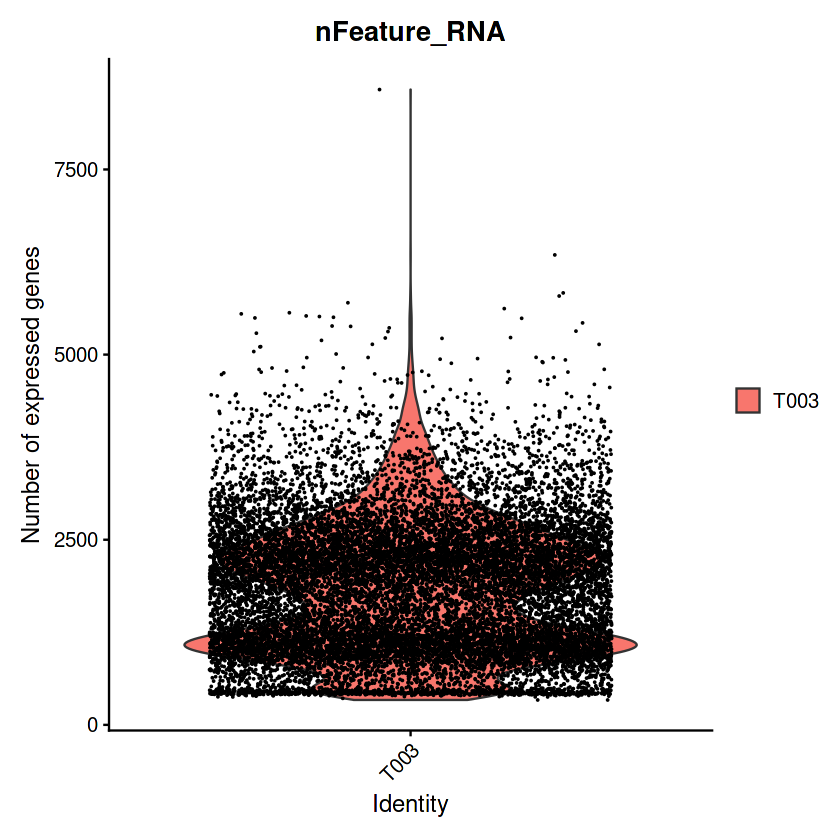

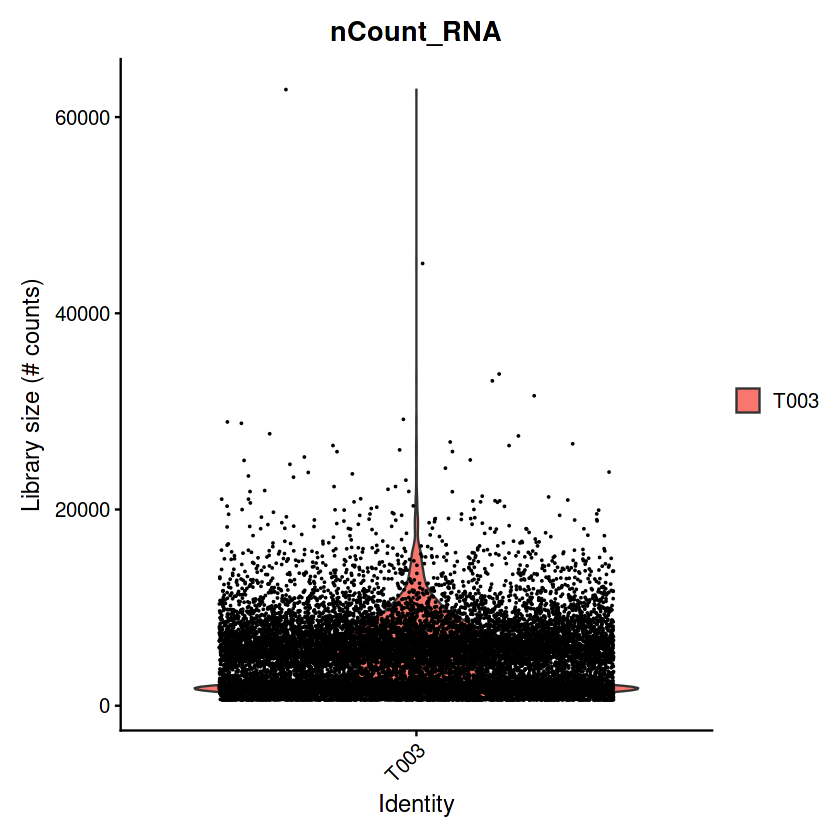

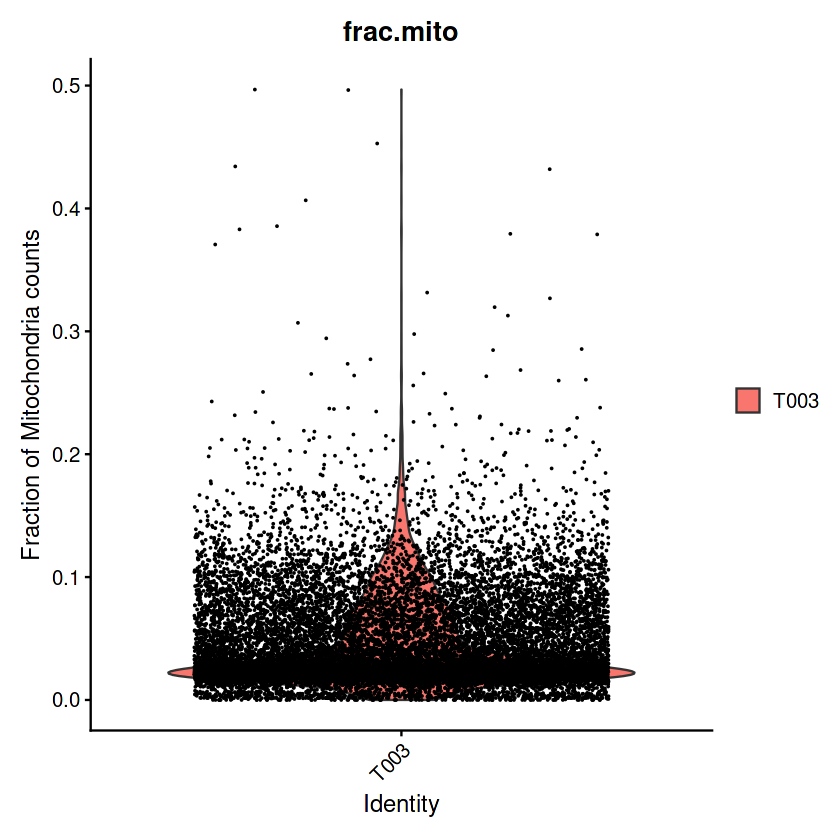

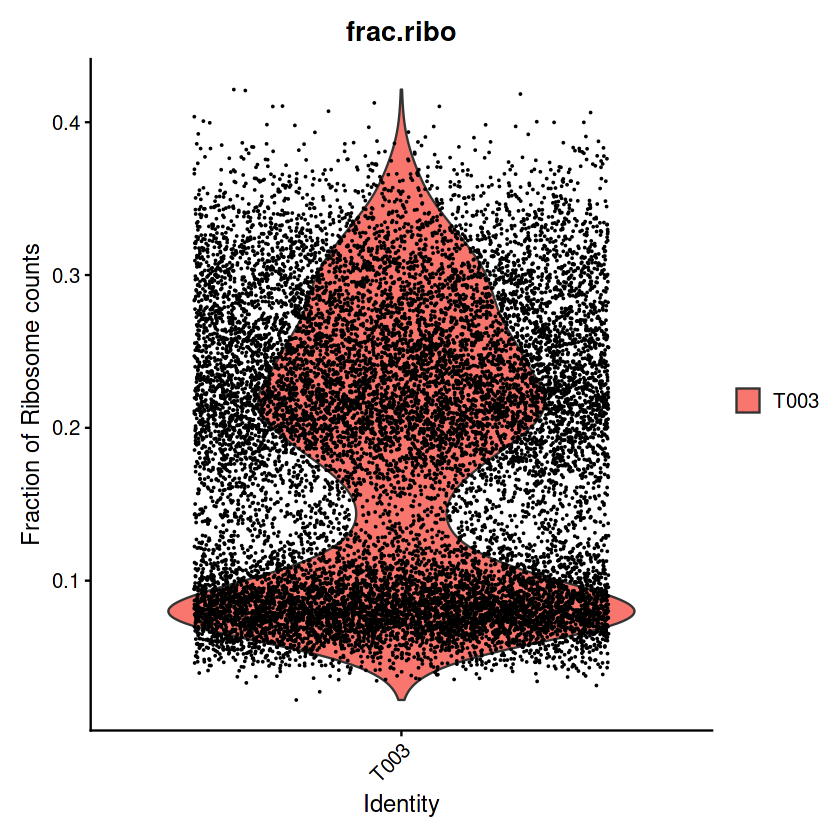

$number_of_genes

$number_of_counts

$frac.mito

$frac.ribo

$num_counts_vs_frac.mito

$num_counts_vs_num_genes


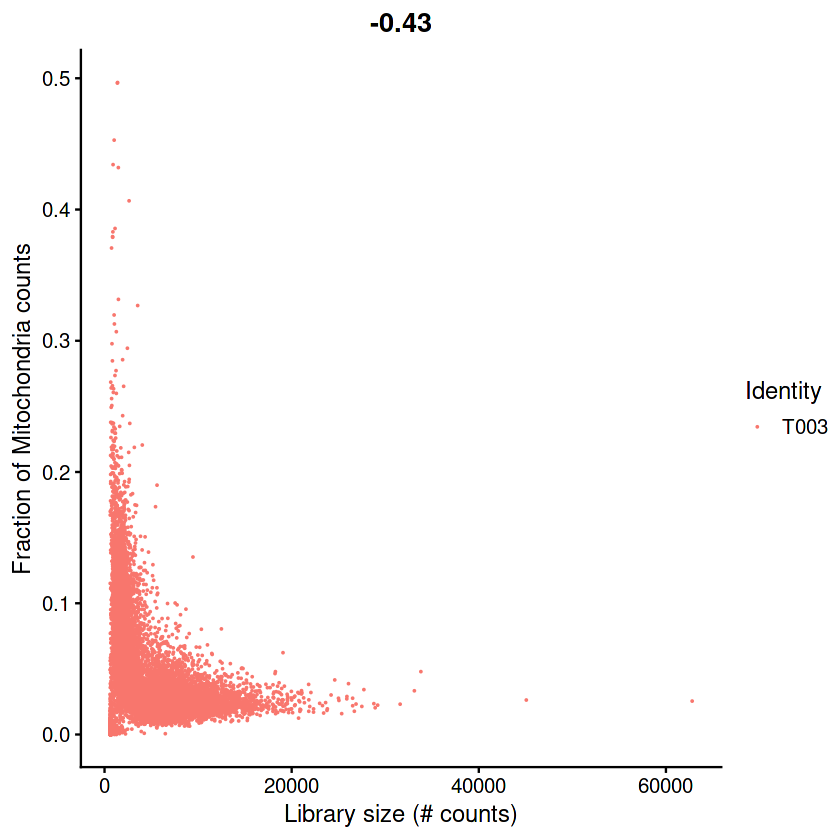

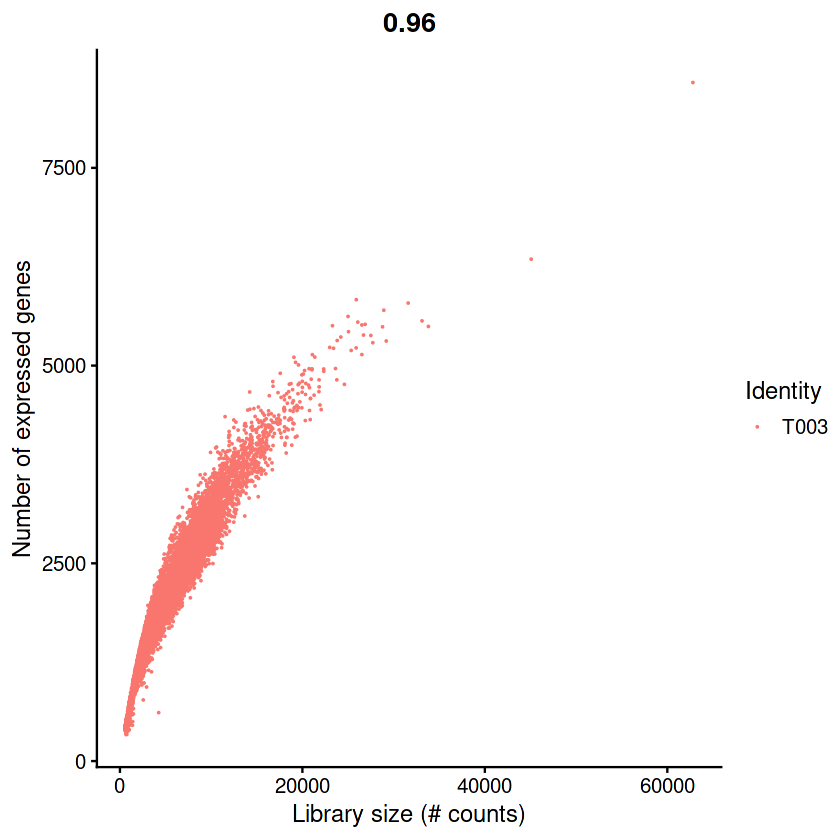

In [9]:
#qc plot before filtering
suppressWarnings(plt<-plot_mito_ribo(seu))
plt

In [10]:
seu@meta.data$Feature_Count_ratio<-
seu@meta.data$nFeature_RNA/seu@meta.data$nCount_RNA
head(seu@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_CITE,nFeature_CITE,frac.mito,frac.ribo,Feature_Count_ratio
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
AAACCTGAGAAACCAT-1,T003,4083,2141,1460,30,0.05951506,0.05975998,0.5243693
AAACCTGAGAAAGTGG-1,T003,5815,2146,2249,30,0.01840069,0.27257094,0.3690456
AAACCTGAGACAAAGG-1,T003,9265,2732,2095,31,0.02536427,0.31969779,0.2948732
AAACCTGAGCCAACAG-1,T003,1234,835,597,23,0.10210697,0.07293355,0.6766613
AAACCTGAGCCCGAAA-1,T003,5294,1985,2110,34,0.03891198,0.26955043,0.3749528
AAACCTGAGCTGATAA-1,T003,6575,2540,2426,40,0.01292776,0.15923954,0.3863118


In [11]:
#filtering cells
frac_mito_threshold <- 0.1
min_num_genes <- 500
max_num_genes <- 5000
#Feature_Count_ratio_threshold<-4000/18000
seu <- subset(seu,
             frac.mito < frac_mito_threshold &
             nFeature_RNA > min_num_genes &
             nFeature_RNA < max_num_genes #&
             #Feature_Count_ratio > Feature_Count_ratio_threshold
             )
seu

An object of class Seurat 
36807 features across 13746 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

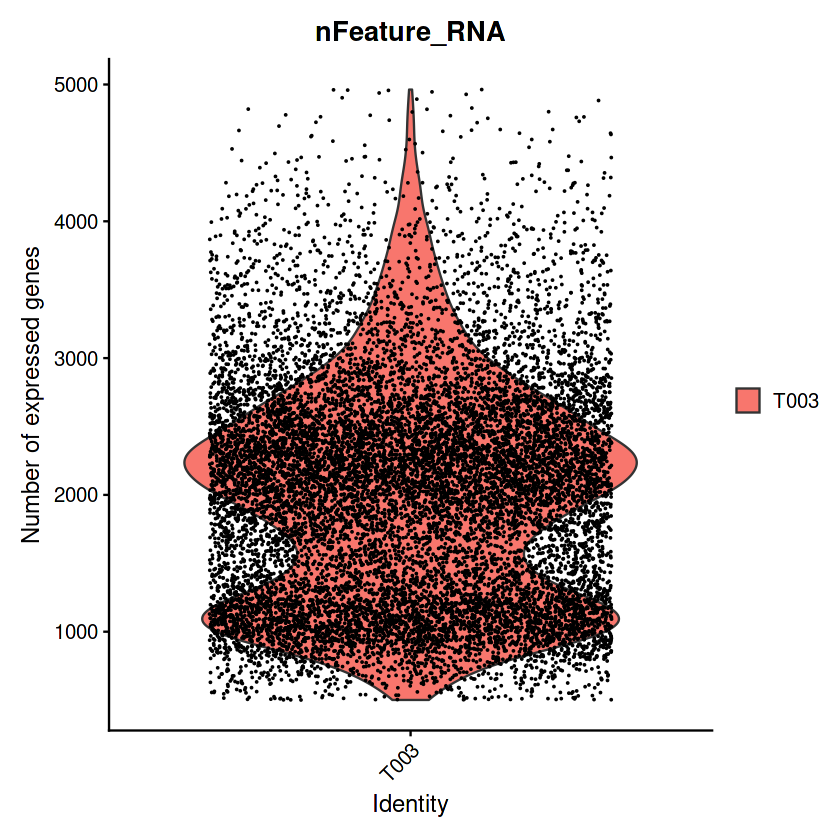

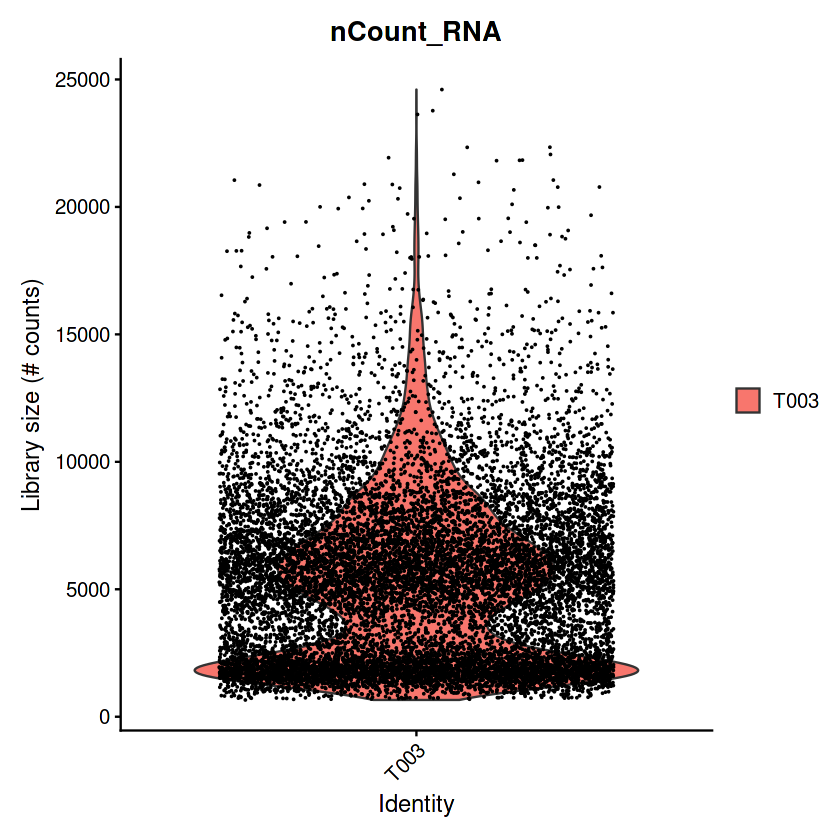

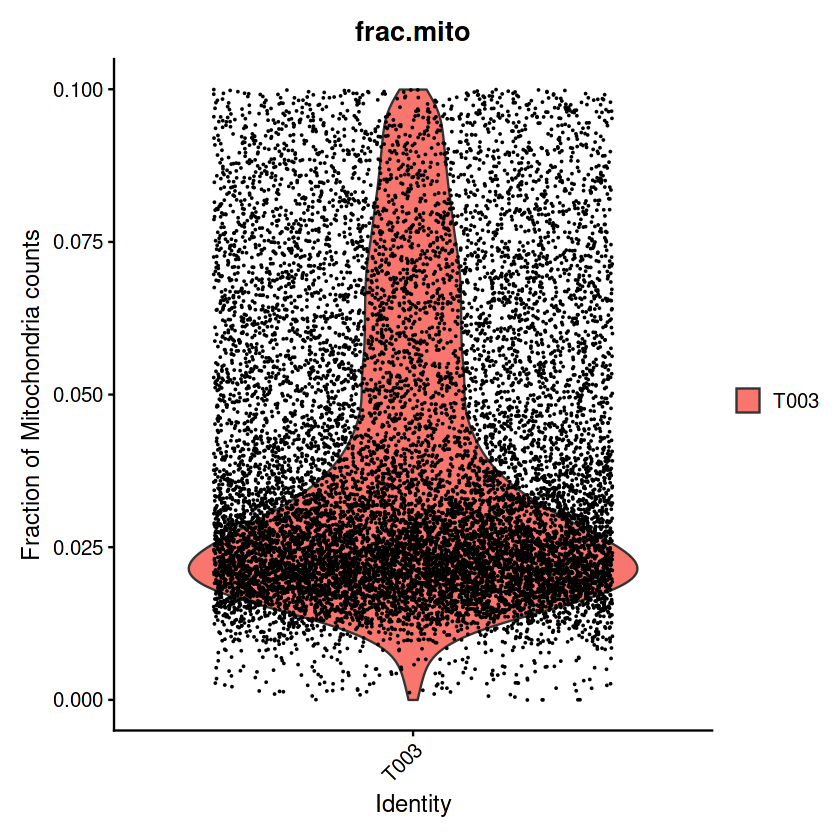

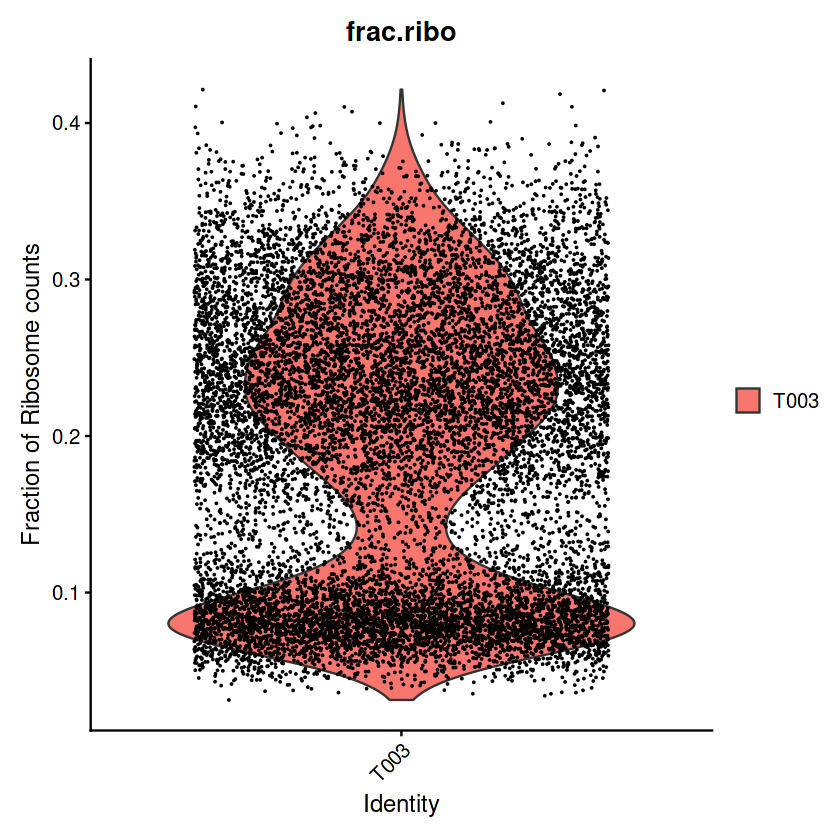

$number_of_genes

$number_of_counts

$frac.mito

$frac.ribo

$num_counts_vs_frac.mito

$num_counts_vs_num_genes


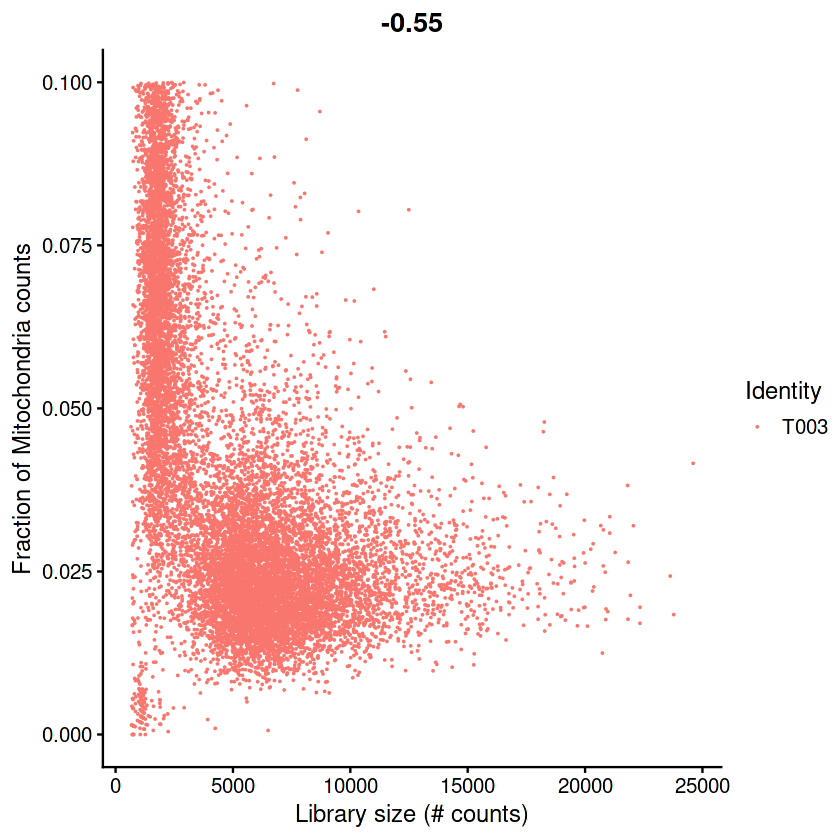

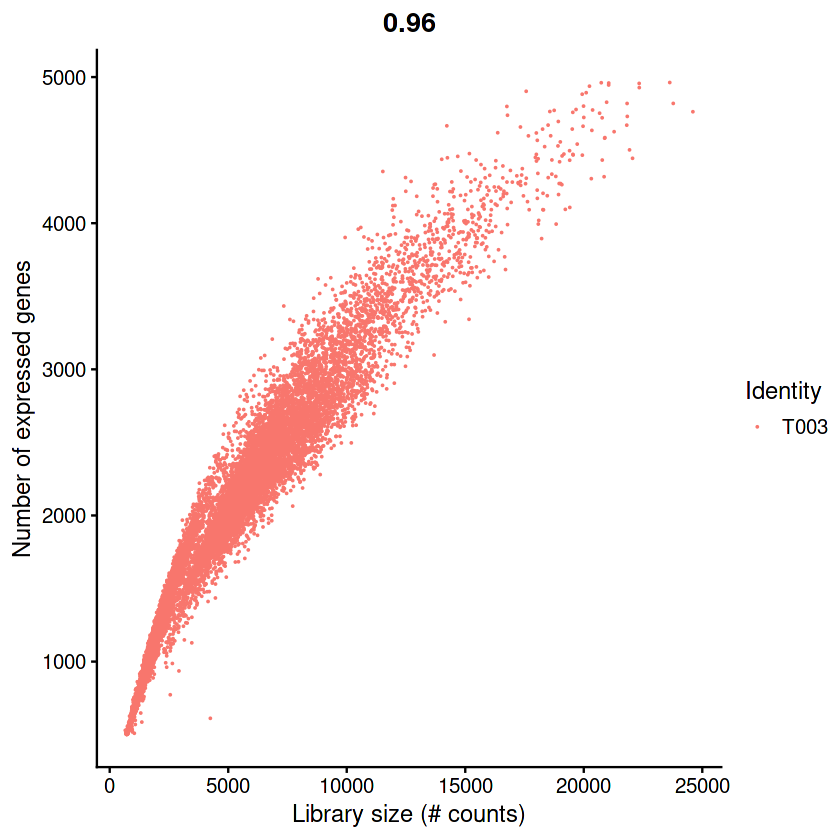

In [12]:
#qc plot after filtering
suppressWarnings(plt<-plot_mito_ribo(seu))
plt

In [13]:
seu

An object of class Seurat 
36807 features across 13746 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: CITE

In [14]:
CD3_genes<-c("CD3D","CD3E","CD3G")
CD3_count<- Matrix::colSums(GetAssayData(
    object = seu, slot = 'counts')[CD3_genes,])
head(CD3_count)
table(CD3_count)
length(CD3_count)
seu[['CD3_count']]<-CD3_count
#seu <- AddMetaData(object = seu, metadata = CD3_count, col.name = "CD3_count")
dim(seu@meta.data)

AAACCTGAGAAACCAT-1 AAACCTGAGAAAGTGG-1 AAACCTGAGACAAAGG-1 AAACCTGAGCCCGAAA-1 
                 5                 13                 25                 19 
AAACCTGAGCTGATAA-1 AAACCTGAGGCCCTTG-1 
                28                 11

CD3_count
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
 604 1129 1108  870  680  427  365  316  356  418  432  513  528  569  592  591 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 524  482  468  389  340  294  268  218  186  142  118  102   91   76   57   49 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
  57   37   48   44   40   26   24   16   21   12   18   17   11    6    6    5 
  48   49   50   51   52   53   55   56   57   59   60   61   62   64   67   69 
   5   10    6    4    1    5    6    3    2    2    1    5    2    1    2    1 

[1] 13746

[1] 13746     9

In [15]:
save_path = file.path(save_dir, paste0(sample_ID, ".rds"))
saveRDS(seu, save_path)